In [16]:
import sys
import os
import math
import logging
import galsim
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect
import argparse
from IPython.display import clear_output
from numpy.random import random_sample
import matplotlib

In [5]:
def Sersic_sigma(half_light_re,n,pixel_scale,sigma):
    light_profile = galsim.Sersic(n, half_light_radius=half_light_re)
    image = light_profile.drawImage(scale = pixel_scale)
    return galsim.hsm.FindAdaptiveMom(image).moments_sigma*pixel_scale-sigma

def Kolmogorov_sigma(half_light_re,pixel_scale,sigma):
    light_profile = galsim.Kolmogorov(half_light_radius=half_light_re)
    image = light_profile.drawImage(scale = pixel_scale)
    return galsim.hsm.FindAdaptiveMom(image).moments_sigma*pixel_scale-sigma

def OpticalPSF_sigma(fwhm,pixel_scale,sigma):
    light_profile = galsim.OpticalPSF(fwhm)
    image = light_profile.drawImage(scale = pixel_scale)
    return galsim.hsm.FindAdaptiveMom(image).moments_sigma*pixel_scale-sigma

In [6]:
class PSFtest:
    
    def __init__(self, gal_type, gal_sigma,e1,e2,psf_type,psf_sigma,size_error,psf_e1,psf_e2,shape_error1,shape_error2,
                gal_flux=1.e2,pixel_scale = 0.1,sersicn = -1,subtract_intersection = True):
        self.gal_type = gal_type
        self.gal_sigma = gal_sigma
        self.psf_type = psf_type
        self.psf_sigma = psf_sigma
        self.psf_model_sigma = psf_sigma+size_error
        self.psf_e1 = psf_e1
        self.psf_e2 = psf_e2
        self.psf_model_e1 = psf_e1+shape_error1
        self.psf_model_e2 = psf_e2+shape_error2
        self.gal_flux=gal_flux
        self.pixel_scale = pixel_scale
        self.e1 = e1
        self.e2 = e2
        self.e = np.sqrt(e1**2+e2**2)
        self.sersicn=sersicn
        self.e_truth = np.sqrt(e1**2+e2**2)
        self.subtract_intersection = subtract_intersection
        if gal_type == "gaussian":
            self.gal_light = galsim.Gaussian(flux = self.gal_flux, sigma = self.gal_sigma)
        elif gal_type == "sersic":
            self.gal_light = self.findAdaptiveSersic(gal_sigma)
        
        self.gal_light = self.gal_light.shear(e1=e1, e2=e2)
            
        
        if psf_type == "gaussian":
            self.psf_light = galsim.Gaussian(flux = 1.0, sigma = psf_sigma)
            self.psf_model_light = galsim.Gaussian(flux = 1.0, sigma = self.psf_model_sigma)
        elif psf_type == "kolmogorov":
            self.psf_light = self.findAdaptiveKolmogorov(self.psf_sigma)
            self.psf_model_light = self.findAdaptiveKolmogorov(self.psf_model_sigma)
        elif psf_type == "opticalPSF":
            self.psf_light = self.findAdaptiveOpticalPSF(self.psf_sigma)
            self.psf_model_light = self.findAdaptiveOpticalPSF(self.psf_model_sigma)
            
        self.psf_light = self.psf_light.shear(e1=psf_e1, e2=psf_e2)
        self.psf_model_light = self.psf_model_light.shear(e1=self.psf_model_e1,e2=self.psf_model_e2)
            
            
    def get_intersection(self):
        image_epsf = self.psf_light.drawImage(scale=self.pixel_scale)
        final = galsim.Convolve([self.gal_light,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        results = galsim.hsm.EstimateShear(image,image_epsf)
        intersection = np.sqrt(results.corrected_e1**2+results.corrected_e2**2)-self.e_truth
        return intersection
    
    def get_prediction(self):
        return self.e_truth*(self.psf_model_sigma**2-self.psf_sigma**2)/self.gal_sigma**2 + (self.psf_sigma/self.gal_sigma)**2*(self.psf_e2-self.psf_model_e2)
    
    def get_measurement(self):
        image_epsf = self.psf_model_light.drawImage(scale = self.pixel_scale)
        final = galsim.Convolve([self.gal_light,self.psf_light])
        image = final.drawImage(scale = self.pixel_scale)
        results = galsim.hsm.EstimateShear(image,image_epsf)
        bias = np.sqrt(results.corrected_e1**2+results.corrected_e2**2)-self.e_truth
        if self.subtract_intersection==True:
            return bias-self.get_intersection()
        else:
            return bias
    
    def findAdaptiveSersic(self,sigma):
        good_half_light_re = bisect(Sersic_sigma,self.gal_sigma/10,self.gal_sigma*10,args=(self.sersicn,self.pixel_scale,sigma))
        return galsim.Sersic(n=self.sersicn,half_light_radius=good_half_light_re)
    
    def findAdaptiveKolmogorov(self,sigma):
        good_half_light_re = bisect(Kolmogorov_sigma,self.psf_sigma/5,self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.Kolmogorov(half_light_radius = good_half_light_re)
    
    def findAdaptiveOpticalPSF(self,sigma):
        good_fwhm = bisect(OpticalPSF_sigma,self.psf_sigma/5,self.psf_sigma*5,args = (self.pixel_scale,sigma))
        return galsim.OpticalPSF(good_fwhm)
        
    
    def real_gal_sigma(self):
        image = self.gal_light.drawImage(scale = self.pixel_scale)
        return galsim.hsm.FindAdaptiveMom(image).moments_sigma*self.pixel_scale
    
    def get_results(self):
        results = dict()
        results["prediction"] = self.get_prediction()
        results["measurement"] = self.get_measurement()

        results["gal_type"] = self.gal_type
        results["psf_type"] = self.psf_type
        results["gal_sigma"] = self.gal_sigma
        results["psf_sigma"] = self.psf_sigma
        results["e1"] = self.e1
        results["e2"] = self.e2
        results["e"] = self.e
        results["sersicn"] = self.sersicn
        results["psf_e1"] = self.psf_e1
        results["psf_e2"] = self.psf_e2
        results["psf_e1_error"] = self.psf_model_e1-self.psf_e1
        results["psf_e2_error"] = self.psf_model_e2-self.psf_e2
        
        results["psf_model_sigma"] = self.psf_model_sigma
        results["psf_model_e1"] = self.psf_model_e1
        results["psf_model_e2"] = self.psf_model_e2

        
        results["prediction-error"] = results["prediction"]-results["measurement"]
        results["prediction-percenterror"] = results["prediction-error"]/results["e"]
        results["measurement-over-prediction"] = results["measurement"]/results["prediction"]
        
        return results
    
    
    
    
    
    

In [35]:
test1 = PSFtest("sersic",2.0,0.0,0.1,                       #gal_type,gal_sigma,e1,e2
                "opticalPSF",0.5,0.01,
                0.0,0.0,0.0,0.0,
                sersicn=1.5,subtract_intersection=True)           #psf_type,psf_sigma,size_error

print test1.get_results()

{'psf_model_sigma': 0.51, 'e': 0.1, 'psf_e1_error': 0.0, 'psf_e2_error': 0.0, 'psf_type': 'opticalPSF', 'psf_model_e1': 0.0, 'prediction-error': -6.267446041107182e-05, 'gal_sigma': 2.0, 'psf_e1': 0.0, 'prediction': 0.00025249999999999996, 'measurement-over-prediction': 1.2482156847963242, 'sersicn': 1.5, 'measurement': 0.0003151744604110718, 'prediction-percenterror': -0.0006267446041107182, 'psf_e2': 0.0, 'e2': 0.1, 'e1': 0.0, 'psf_model_e2': 0.0, 'psf_sigma': 0.5, 'gal_type': 'sersic'}


In [36]:
# different type of galaxy and different type of psf light profile, but with 2.0 gal_sig and 0.6 psf_sig
#       gal_type   ,gal_sig,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test2= [("gaussian" ,2.0    ,0.0,0.1,"gaussian"   ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True}),
       ("gaussian" ,2.0    ,0.0,0.1,"kolmogorov" ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True}),
       ("gaussian" ,2.0    ,0.0,0.1,"opticalPSF" ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True}),
       ("sersic"   ,2.0    ,0.0,0.1,"gaussian"   ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':1}),
       ("sersic"   ,2.0    ,0.0,0.1,"kolmogorov" ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':1}),
       ("sersic"   ,2.0    ,0.0,0.1,"opticalPSF" ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':1}),
       ("sersic"   ,2.0    ,0.0,0.1,"gaussian"   ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':3}),
       ("sersic"   ,2.0    ,0.0,0.1,"kolmogorov" ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':3}),
       ("sersic"   ,2.0    ,0.0,0.1,"opticalPSF" ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':3}),
      ]

In [37]:
test2result = []
for i in range(len(test2)):
    test = PSFtest(*test2[i][:-1],**test2[i][-1])
    results = test.get_results()
    print results["gal_type"],results["psf_type"],results['measurement-over-prediction']
    test2result.append(results)

gaussian gaussian 1.0107088088989515
gaussian kolmogorov 1.1070919036864248
gaussian opticalPSF 0.87658405303955
sersic gaussian 1.2849140167236583
sersic kolmogorov 1.3543224334716164
sersic opticalPSF 1.0542011260987474
sersic gaussian 1.517558097839283
sersic kolmogorov 1.5215063095092316
sersic opticalPSF 1.1158561706541272


In [38]:
#gal_sigma varies from 0.6 arcsec to 3 arcsec, for sersic n = 3 galaxy on gaussian psf (1 arcsec)
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test3 = [("sersic"   ,0.6+0.1*i    ,0.0,0.1,"gaussian" ,1.0    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':3}) for i in range(20)
      ]

In [50]:
test3result=[]
for i in range(len(test3)):
    test = PSFtest(*test3[i][:-1],**test3[i][-1])
    results = test.get_results()
    test3result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test3)*100)+"%")

Finished 100.0%


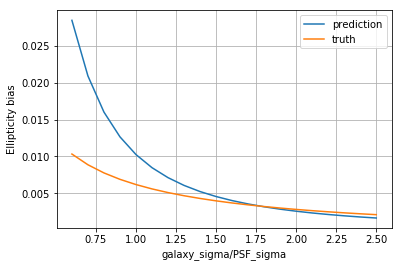

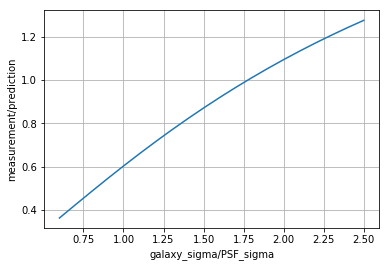

In [128]:
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test3result],[t["prediction"] for t in test3result],label='prediction')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test3result],[t["measurement"] for t in test3result],label='truth')
plt.xlabel("galaxy_sigma/PSF_sigma")
plt.ylabel("Ellipticity bias")
plt.legend()
plt.grid()
plt.show()
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test3result],[t["measurement-over-prediction"] for t in test3result])
plt.xlabel("galaxy_sigma/PSF_sigma")
plt.ylabel("measurement/prediction")
plt.grid()
plt.show()

In [132]:
#Sersic galaxy (2.0 arcsec) but different n (from 1 to 3), on gaussian psf, test how bad the prediction on Sersic profile
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test4 = [("sersic"   ,2.0    ,0.0,0.1,"gaussian" ,0.6    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':0.5+0.2*i,'pixel_scale':0.2}) for i in range(18)
      ]

In [133]:
test4result=[]
for i in range(len(test4)):
    test = PSFtest(*test4[i][:-1],**test4[i][-1])
    results = test.get_results()
    test4result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test4)*100)+"%")

Finished 100.0%


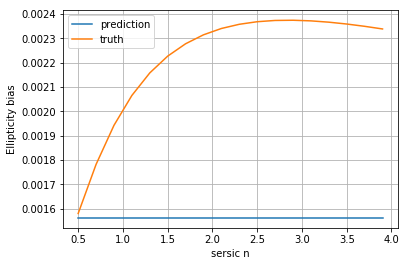

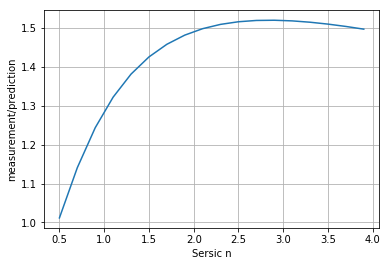

In [135]:
plt.plot([t["sersicn"] for t in test4result],[t["prediction"] for t in test4result],label='prediction')
plt.plot([t["sersicn"] for t in test4result],[t["measurement"] for t in test4result],label='truth')
plt.xlabel("sersic n")
plt.ylabel("Ellipticity bias")
plt.legend()
plt.grid()
plt.show()

plt.plot([t["sersicn"] for t in test4result],[t["measurement-over-prediction"] for t in test4result])
plt.xlabel("Sersic n")
plt.ylabel("measurement/prediction")
plt.grid()
plt.show()

In [136]:
#
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test5 = [("sersic"   ,1.5    ,0.0,0.1,"opticalPSF" ,0.3+0.1*i    ,0.05 ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':3}) for i in range(20)
        ]





In [137]:
test5result=[]
for i in range(len(test5)):
    test = PSFtest(*test5[i][:-1],**test5[i][-1])
    results = test.get_results()
    test5result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test5)*100)+"%")

Finished 100.0%


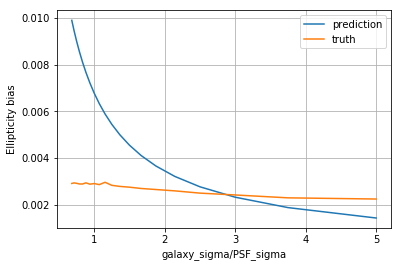

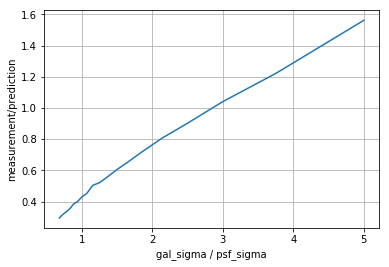

In [138]:
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test5result],[t["prediction"] for t in test5result],label='prediction')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test5result],[t["measurement"] for t in test5result],label='truth')
plt.xlabel("galaxy_sigma/PSF_sigma")
plt.ylabel("Ellipticity bias")
plt.legend()
plt.grid()
plt.show()

plt.plot([t["gal_sigma"]/t["psf_sigma"] for t in test5result],[t["measurement-over-prediction"] for t in test5result])
plt.xlabel("gal_sigma / psf_sigma")
plt.ylabel("measurement/prediction")
plt.grid()
plt.show()


In [88]:
# shape error functional testing
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig  ,size_error, psfe1, psfe2, psfe1_error, psfe2_error   ,optionals    
test6 = [("gaussian"   ,1.0    ,0.0,0.1,"gaussian"   ,0.6      ,0.0       , 0  ,   0.3  , 0          ,-0.01+0.001*i, {'subtract_intersection':True}) for i in range(20)
      ]

In [89]:
test6result=[]
for i in range(len(test6)):
    test = PSFtest(*test6[i][:-1],**test6[i][-1])
    results = test.get_results()
    test6result.append(results)

/Users/zhangtianqing/miniconda2/envs/galsim_env/lib/python2.7/site-packages/ipykernel_launcher.py:108: RuntimeWarning: invalid value encountered in double_scalars


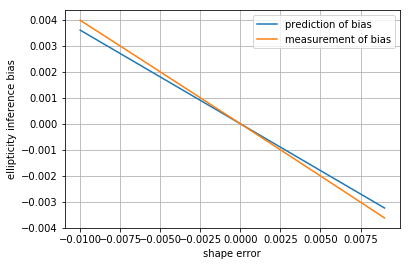

In [139]:
plt.plot([t["psf_e2_error"] for t in test6result],[t["prediction"] for t in test6result],label="prediction of bias")
plt.plot([t["psf_e2_error"] for t in test6result],[t["measurement"] for t in test6result],label="measurement of bias")
plt.xlabel("shape error")
plt.ylabel("ellipticity inference bias")
plt.legend()
plt.grid()
plt.show()


In [93]:
# shape error functional testing
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig  ,size_error, psfe1, psfe2, psfe1_error, psfe2_error   ,optionals    
test7 = [("gaussian"   ,1.0    ,0.0,0.1,"gaussian"   ,0.6      ,0.0       , 0  ,   0.05+0.01*i  , 0          ,0.01, {'subtract_intersection':True,'sersicn':3}) for i in range(20)
      ]

In [94]:
test7result=[]
for i in range(len(test7)):
    test = PSFtest(*test7[i][:-1],**test7[i][-1])
    results = test.get_results()
    test7result.append(results)

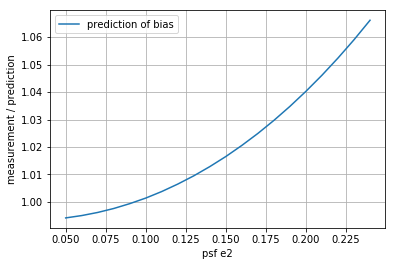

In [140]:


plt.plot([t["psf_e2"] for t in test7result],[t["measurement-over-prediction"] for t in test7result],label="prediction of bias")
plt.xlabel("psf e2")
plt.ylabel("measurement / prediction")
plt.legend()
plt.grid()
plt.show()

In [104]:
# shape error functional testing
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig  ,size_error, psfe1, psfe2, psfe1_error, psfe2_error   ,optionals    
test8 = [("sersic"   ,0.6+0.1*i    ,0.0,0.1,"opticalPSF"   ,1.0      ,0.0       , 0  ,  0.2  , 0          ,0.05, {'subtract_intersection':True,'sersicn':2}) for i in range(17)
      ]

In [105]:
test8result=[]
for i in range(len(test8)):
    test = PSFtest(*test8[i][:-1],**test8[i][-1])
    results = test.get_results()
    test8result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test8)*100)+"%")

Finished 100.0%


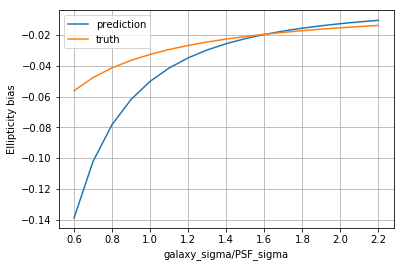

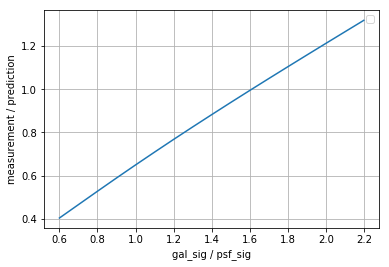

In [141]:
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test8result],[t["prediction"] for t in test8result],label='prediction')
plt.plot([t['gal_sigma']/t['psf_sigma'] for t in test8result],[t["measurement"] for t in test8result],label='truth')
plt.xlabel("galaxy_sigma/PSF_sigma")
plt.ylabel("Ellipticity bias")
plt.legend()
plt.grid()
plt.show()


plt.plot([t["gal_sigma"]/t["psf_sigma"] for t in test8result],[t["measurement-over-prediction"] for t in test8result])
plt.xlabel("gal_sig / psf_sig")
plt.ylabel("measurement / prediction")
plt.legend()
plt.grid()
plt.show()

In [7]:
#Sersic galaxy (2.0 arcsec) but different n (from 1 to 3), on gaussian psf, test how bad the prediction on Sersic profile
#       gal_type   ,gal_sig    ,e1 ,e2 , psf_type    ,psf_sig,SE   ,optionals    
test9 = [("sersic"   ,2.0    ,0.0,0.1,"gaussian" ,0.6    ,0 ,0.0,0.2,0.0,0.05,{'subtract_intersection':True,'sersicn':0.5+0.2*i,'pixel_scale':0.2}) for i in range(18)
      ]

In [8]:
test9result=[]
for i in range(len(test9)):
    test = PSFtest(*test9[i][:-1],**test9[i][-1])
    results = test.get_results()
    test9result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test9)*100)+"%")

Finished 100.0%


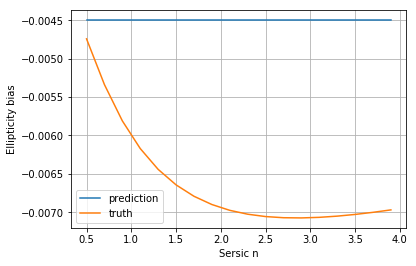

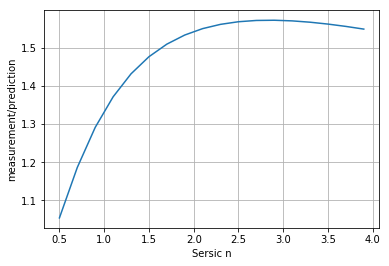

In [10]:
plt.plot([t["sersicn"] for t in test9result],[t["prediction"] for t in test9result],label='prediction')
plt.plot([t["sersicn"] for t in test9result],[t["measurement"] for t in test9result],label='truth')
plt.xlabel("Sersic n")
plt.ylabel("Ellipticity bias")
plt.legend()
plt.grid()
plt.show()

plt.plot([t["sersicn"] for t in test9result],[t["measurement-over-prediction"] for t in test9result])
plt.xlabel("Sersic n")
plt.ylabel("measurement/prediction")
plt.grid()
plt.show()

In [101]:
# A more general test for size error
# Randomize galaxy size from 1-3 arcsec
# Randomize PSF size from  0.3-1.5 arcsec
# Randomize galaxy e2 from 0-0.5
# Randomize size_error from 0.01-0.05 arcsec
# Fix galaxy type as Sersic, but n varies from 0.5-3
# Use Kolmogorov PSF and Optical PSF, each have 100 samples
test11=[]
for i in range():
    test11.append(("sersic"   ,1+2*random_sample()    ,0.0,0.5*random_sample(),"kolmogorov" ,0.3+1.2*random_sample()    ,0.01+0.04*random_sample() ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':0.5+2.5*random_sample()}))
    test11.append(("sersic"   ,1+2*random_sample()    ,0.0,0.5*random_sample(),"opticalPSF" ,0.3+1.2*random_sample()    ,0.01+0.04*random_sample() ,0.0,0.0,0.0,0.0,{'subtract_intersection':True,'sersicn':0.5+2.5*random_sample()}))
    
    
    
    

In [102]:
test11result=[]
for i in range(len(test11)):
    try:
        test = PSFtest(*test11[i][:-1],**test11[i][-1])
    except:
        print "An error occurs here"
        continue
    results = test.get_results()
    test11result.append(results)
    clear_output() 
    print ("Finished "+str(float((i+1))/len(test11)*100)+"%")

Finished 100.0%


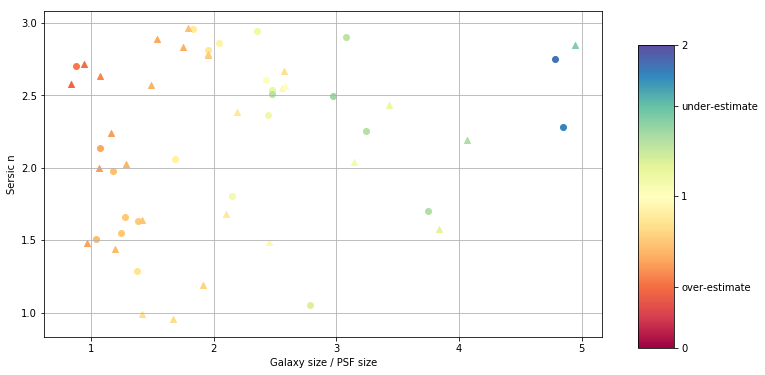

In [109]:
# Visualization section
fig, ax = plt.subplots(figsize=(10,6))
plt.grid()
plt.xlabel("Galaxy size / PSF size")
plt.ylabel("Sersic n")
cmap = matplotlib.cm.get_cmap('Spectral')
cax = fig.add_axes([0.95, 0.1, 0.05, 0.7])
cbar=matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap, 
                                 orientation="vertical",ticks=[0,0.2, 0.5,0.8 ,1])
cbar.ax.set_yticklabels(['0','over-estimate', '1','under-estimate', '2']) 
for result in test11result:
    goodness=(result["measurement-over-prediction"]-1)/2+0.5
    if result['psf_type']=="opticalPSF":
        ax.scatter([result["gal_sigma"]/result["psf_sigma"]], [result["sersicn"]],marker='^',color=cmap(goodness),cmap=cmap)
#         plt.plot([result["gal_sigma"]/result["psf_sigma"]],[result["sersicn"]],'v',color=cmap(goodness))
    else:
        ax.scatter([result["gal_sigma"]/result["psf_sigma"]], [result["sersicn"]] ,color=cmap(goodness),cmap=cmap)
#         plt.plot([result["gal_sigma"]/result["psf_sigma"]],[result["sersicn"]],'o',color=cmap(goodness))


plt.show()
    

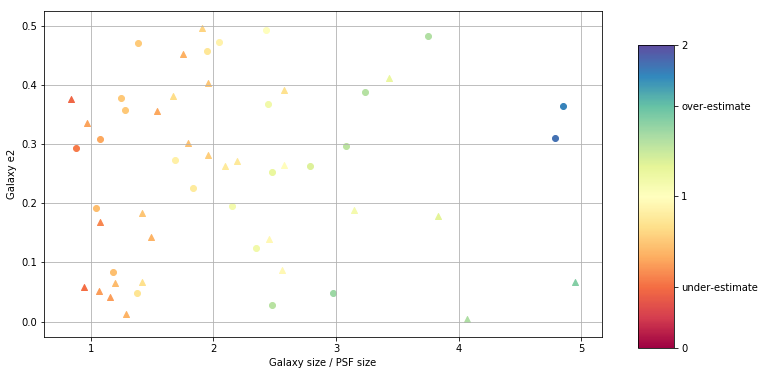

In [108]:
# Visualization section
fig, ax = plt.subplots(figsize=(10,6))
plt.grid()
plt.xlabel("Galaxy size / PSF size")
plt.ylabel("Galaxy e2")
cmap = matplotlib.cm.get_cmap('Spectral')
cax = fig.add_axes([0.95, 0.1, 0.05, 0.7])
cbar=matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap, 
                                 orientation="vertical",ticks=[0,0.2, 0.5,0.8 ,1])
cbar.ax.set_yticklabels(['0','under-estimate', '1','over-estimate', '2']) 
for result in test11result:
    goodness=(result["measurement-over-prediction"]-1)/2+0.5
    if result['psf_type']=="opticalPSF":
        ax.scatter([result["gal_sigma"]/result["psf_sigma"]], [result["e2"]],marker='^',color=cmap(goodness),cmap=cmap)
#         plt.plot([result["gal_sigma"]/result["psf_sigma"]],[result["sersicn"]],'v',color=cmap(goodness))
    else:
        ax.scatter([result["gal_sigma"]/result["psf_sigma"]], [result["e2"]] ,color=cmap(goodness),cmap=cmap)
#         plt.plot([result["gal_sigma"]/result["psf_sigma"]],[result["sersicn"]],'o',color=cmap(goodness))


plt.show()
    